In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [3]:
# Perform ADF Test and print results
result = adfuller(data['aapl_adj_close'])
print(f'ADF Test for AAPL Stock Price:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
print('---\n')
# Determine if the series is stationary
p_value = result[1]
if p_value < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")
print('---\n')

ADF Test for AAPL Stock Price:
ADF Statistic: -0.08836021695954817
p-value: 0.9505856301965474
Critical Value (1%): -3.4340519866364954
Critical Value (5%): -2.8631752211631247
Critical Value (10%): -2.5676405414939345
---

The data is non-stationary (fail to reject the null hypothesis).
---



In [4]:
diff_data = data['aapl_adj_close'].diff().dropna()

In [5]:
# Perform ADF Test and print results
result = adfuller(diff_data)
print(f'ADF Test for Differenced AAPL Stock Price:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')
print('---\n')
# Determine if the series is stationary
p_value = result[1]
if p_value < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")
print('---\n')

ADF Test for Differenced AAPL Stock Price:
ADF Statistic: -42.56427958822331
p-value: 0.0
Critical Value (1%): -3.434054083572257
Critical Value (5%): -2.8631761468358614
Critical Value (10%): -2.567641034389652
---

The data is stationary (reject the null hypothesis).
---



# Normalise Data

In [6]:
y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)


# Train-Test Split

In [7]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X_scaled[:ntrain], X_scaled[ntrain:]
y_train, y_test = y_scaled[:ntrain], y_scaled[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


# ARIMA Model

In [8]:
# Function to evaluate ARIMA model
def evaluate_arima_model(y_train, y_test, arima_order):
    # Fit the ARIMA model on the training set (target only)
    model = ARIMA(y_train, order=arima_order)
    model_fit = model.fit()
    
    # Forecasting the test set period
    forecast = model_fit.forecast(steps=len(y_test))
    
    # Calculate RMSE between actual test set and the forecast
    error = root_mean_squared_error(y_test, forecast)
    
    return error

In [9]:
# Grid search for ARIMA hyperparameters (p, d, q)
def grid_search_arima(y_train, y_test, p_values, d_values, q_values):
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(y_train, y_test, order)
                    if rmse < best_score:
                        best_score, best_order = rmse, order
                    print(f'ARIMA{order} RMSE={rmse}')
                except:
                    continue
    print(f'Best ARIMA model: ARIMA{best_order} with MSE={best_score}')
    return best_order

In [10]:
# Define the range for p, d, and q 
p_values = range(0, 3)  # Try p = 0, 1, 2
d_values = range(0, 2)  # Try d = 0, 1 (first differencing)
q_values = range(0, 3)  # Try q = 0, 1, 2

In [11]:
# Perform grid search to find the best (p, d, q) values for ARIMA model
best_order = grid_search_arima(y_train, y_test, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.6685929650306184
ARIMA(0, 0, 1) RMSE=1.6675630548890563
ARIMA(0, 0, 2) RMSE=1.6666381294051413
ARIMA(0, 1, 0) RMSE=0.5262053642964667
ARIMA(0, 1, 1) RMSE=0.5253629009496265
ARIMA(0, 1, 2) RMSE=0.5244941828720012
ARIMA(1, 0, 0) RMSE=0.6878899446644163
ARIMA(1, 0, 1) RMSE=0.6693350659768549
ARIMA(1, 0, 2) RMSE=0.663391342565613
ARIMA(1, 1, 0) RMSE=0.5254770588787014
ARIMA(1, 1, 1) RMSE=0.5250351931519738
ARIMA(1, 1, 2) RMSE=0.5243405729827953
ARIMA(2, 0, 0) RMSE=0.668541672237654
ARIMA(2, 0, 1) RMSE=0.649436755925256
ARIMA(2, 0, 2) RMSE=0.5877589417152773
ARIMA(2, 1, 0) RMSE=0.5246739623929134
ARIMA(2, 1, 1) RMSE=0.5263803605130373
ARIMA(2, 1, 2) RMSE=0.5245671119044343
Best ARIMA model: ARIMA(1, 1, 2) with MSE=0.5243405729827953


### ARIMA Model Selection
The ARIMA model was chosen based on the grid search over different values of p, d, and q. These parameters represent the following:

- **p**: Number of lag observations included (Auto-regressive part)
- **d**: Degree of differencing (to make the data stationary)
- **q**: Size of the moving average window

The grid search selected the best combination of parameters based on the lowest **AIC** (Akaike Information Criterion) or **MSE** (Mean Squared Error). Lower values of AIC/BIC indicate a better-fitting model.

In [12]:
# Fit the best ARIMA model on the full training data
model = ARIMA(y_train, order=best_order)
model_fit = model.fit()

In [13]:
# Print the summary of the best ARIMA model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         aapl_adj_close   No. Observations:                 1416
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2652.902
Date:                Wed, 30 Oct 2024   AIC                          -5297.805
Time:                        11:20:31   BIC                          -5276.785
Sample:                             0   HQIC                         -5289.951
                               - 1416                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3135      0.556      0.564      0.573      -0.775       1.402
ma.L1         -0.3675      0.558     -0.659      0.510      -1.460       0.725
ma.L2         -0.0130      0.041     -0.319      0.7

### ARIMA Model Forecast vs. Actual Test Data
In this plot, we compare the ARIMA model's forecast against the actual test data. The model was trained on 80% of the dataset and used to forecast the remaining 20% (test set).

The red line represents the model’s forecast, while the blue line represents the actual test data. The closer these lines are, the more accurate the model is.

In [14]:
# Forecast the test set period
forecast = model_fit.forecast(steps=len(y_test))

# Inverse transform forecast and actual values to original scale
forecast_unscaled = scaler_y.inverse_transform(forecast.to_numpy().reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_train_unscaled = scaler_y.inverse_transform(y_train)

### ARIMA Model Performance Analysis
Visual Analysis: From the forecast plot, we can observe that the predicted values (red line) deviate significantly from the actual stock prices (orange line) in several areas. This indicates that the ARIMA model struggled to capture some of the underlying trends and volatility in the data. The stock prices exhibited complex patterns, including sharp rises and falls, which the ARIMA model could not fully accommodate.

In [17]:
# Inverse transformation for better interpretability
y_train_unscaled = pd.Series(y_train_unscaled.flatten(), index=y_train.index)
y_test_unscaled = pd.Series(y_test_unscaled.flatten(), index=y_test.index)
forecast_unscaled = pd.Series(forecast_unscaled.flatten(), index=y_test.index)

plt.figure(figsize=(10, 6))
plt.plot(y_train_unscaled.index, y_train_unscaled, label='Train Data (Unscaled)')
plt.plot(y_test_unscaled.index, y_test_unscaled, label='Actual Test Data (Unscaled)')
plt.plot(forecast_unscaled.index, forecast_unscaled, label='Forecast (Unscaled)', color='red')
plt.title('ARIMA Model Forecast vs Actual Test Data (Unscaled)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

AttributeError: 'Series' object has no attribute 'flatten'

### Quantitative Analysis: 

The performance of the ARIMA model was further evaluated using the following error metrics - RMSE and MAE.

Interpretation: RMSE and MAE are approximately 100% of the average stock price. Such high error values suggest that the model may not be fully effective in forecasting stock prices, especially in financial time series where even small deviations can significantly impact predictive accuracy. These high errors also imply that the ARIMA model may not be accounting well for the volatility. There is a need to explore more advanced models, such as SARIMA, ARIMAX or LSTMs.

In [19]:
rmse = root_mean_squared_error(y_test_unscaled, forecast)
mae = mean_absolute_error(y_test_unscaled, forecast)
mape = mean_absolute_percentage_error(y_test_unscaled, forecast) * 100

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Root Mean Squared Error (RMSE): 189.98267082265536
Mean Absolute Error (MAE): 189.0875131762852
Mean Absolute Percentage Error (MAPE): 99.52434468221833


In [20]:
# Calculate average stock price in y_test for comparison
average_price = np.mean(y_test_unscaled)

# Calculate percentage of RMSE and MAE relative to the average price
rmse_percentage = (rmse / average_price) * 100
mae_percentage = (mae / average_price) * 100
mape_percentage = (mape / average_price) * 100

print(f'Average Stock Price in Test Set: {average_price}')
print(f'RMSE as percentage of average price: {rmse_percentage}%')
print(f'MAE as percentage of average price: {mae_percentage}%')
print(f'MAPE as percentage of average price: {mape_percentage}%')

Average Stock Price in Test Set: 189.98330093642411
RMSE as percentage of average price: 99.9996683320241%
MAE as percentage of average price: 99.52849131701387%
MAPE as percentage of average price: 52.385838224551684%


# Sliding window ARIMA with exogenous variables (ARIMAX)

To better capture dynamic changes in financial data, this approach re-trains the model on a sliding window basis. Using exogenous variables adds external influences to improve prediction accuracy. We implement 2 adjustments:
1. Sliding Window ARIMA: A rolling window approach to allow the model to continually re-train on the latest data, adapting better to recent market changes while preserving historical patterns, which is essential for dynamic financial series.
2. Exogenous Variables (ARIMAX): Including external variables (other stocks - MSFT, GOOGL, AMZN, TSLA, META) could add predictive power to the model by accounting for factors beyond historical stock prices

In [21]:
# Initialize parameters

# The 60-day window size is a reasonable one as it provides roughly two months of recent data to capture short-term trends while maintaining adaptability to new patterns
window_size = 60  
#  Based on prior ARIMA analysis, fine-tuned with grid search
p, d, q = 1, 1, 2  

In [22]:
# This model will re-train on each 60-day window to better predict the next data point.
# Lists to store predictions
predictions = []

# Iterate over the test set with a sliding window
for i in range(len(y_test)):
    # Define training data for the current window
    X_window = pd.concat([X_train, X_test.iloc[:i]]).iloc[-window_size:]
    y_window = pd.concat([y_train, y_test.iloc[:i]]).iloc[-window_size:]

    # Fit the ARIMAX model on the window
    model = ARIMA(endog=y_window, exog=X_window, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast the next step using the current window model
    forecast = model_fit.forecast(steps=1, exog=X_test.iloc[i:i+1])
    
    # Store the prediction
    predictions.append(forecast.values[0])

# Inverse transformation for better interpretability 
y_test_unscaled = scaler_y.inverse_transform(y_test)
predictions_unscaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

### Sliding Window ARIMAX Forecast Results

The sliding window ARIMAX model was applied, with a 60-day window to continually update the model with recent data. Predictions are generated iteratively for each time step in the test set.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

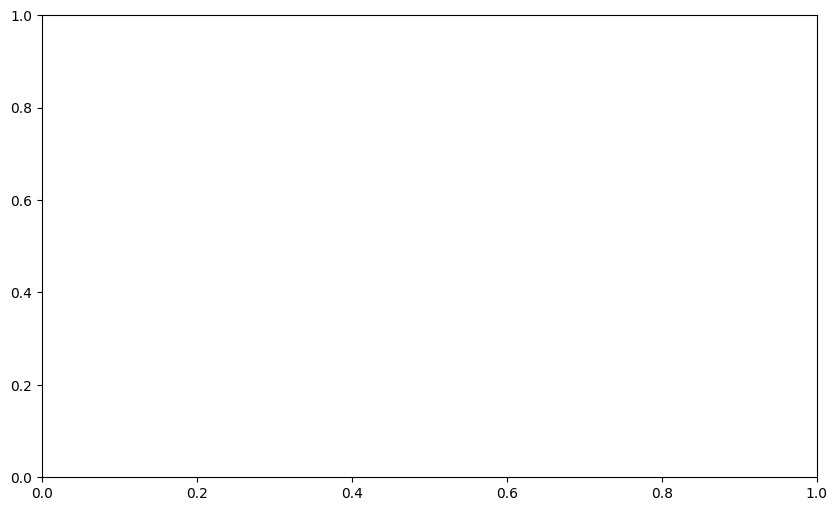

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(y.index[ntrain:], y_test_unscaled, label='Actual Test Data')
plt.plot(y.index[ntrain:], predictions_unscaled, color='red', label='ARIMAX Sliding Window Forecast')
plt.title('ARIMAX Sliding Window Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Quantitative Analysis

With RMSE and MAE values at 1.63% and 1.15% of the average stock price, respectively, the ARIMAX model shows strong predictive performance, capturing the general trend of stock prices with minimal error. In the context of financial time series data, where high volatility and complex patterns are typical, these results suggest that the ARIMAX model is well-suited to this dataset.

In [24]:
# Calculate RMSE and MAE
rmse = root_mean_squared_error(y_test_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_unscaled, predictions_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled) * 100

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Root Mean Squared Error (RMSE): 3.106412970913678
Mean Absolute Error (MAE): 2.202864585712675
Mean Absolute Percentage Error (MAPE): 1.1550555067424364


In [25]:
# Calculate average stock price in y_test_unscaled for comparison
average_price = np.mean(y_test_unscaled)

# Calculate RMSE and MAE as percentages of the average stock price
rmse_percentage = (rmse / average_price) * 100
mae_percentage = (mae / average_price) * 100
mape_percentage = (mape / average_price) * 100

print(f'Average Stock Price in Test Set: {average_price}')
print(f'RMSE as percentage of average price: {rmse_percentage:.2f}%')
print(f'MAE as percentage of average price: {mae_percentage:.2f}%')
print(f'MAPE as percentage of average price: {mape_percentage:.2f}%')

Average Stock Price in Test Set: 189.98330093642411
RMSE as percentage of average price: 1.64%
MAE as percentage of average price: 1.16%
MAPE as percentage of average price: 0.61%
